# 05 - 线性回归的惊人有效性


## 万物皆可回归

在处理因果推断时，我们观察到每个个体存在两种潜在结果：$Y_0$ 表示个体未接受处理时的结果，$Y_1$ 则表示其接受处理后的结果。将处理变量 $T$ 设定为 0 或 1 的行为，会具体化其中一种潜在结果，并使我们永远无法知晓另一种结果。这导致个体处理效应 $\tau_i = Y_{1i} - Y_{0i}$ 成为不可知量。

$
Y_i = Y_{0i} + T_i(Y_{1i} - Y_{0i}) = Y_{0i}(1-T_i) + T_i Y_{1i}
$

因此，目前让我们聚焦于估算平均因果效应这一更简单的任务。基于此，我们既承认不同个体对处理的反应存在差异，也接受无法具体识别哪些个体反应更佳的事实。相反，我们将仅试图从**平均意义上**验证处理是否有效。

$
ATE = E[Y_1 - Y_0]
$

这将为我们提供一个简化模型，其中处理效应为常数 $Y_{1i} = Y_{0i} + \kappa$。若 $\kappa$ 为正，则表明该处理平均而言具有积极效果。即便部分个体反应不佳，整体影响仍呈正面。

还需注意的是，由于存在偏误，我们无法直接通过均值差 $E[Y|T=1] - E[Y|T=0]$ 来估计 $E[Y_1 - Y_0]$。当处理组与对照组因非处理因素存在差异时，常会产生此类偏误。理解这一点可观察其在潜在结果 $Y_0$ 上的差异表现。

$
E[Y|T=1] - E[Y|T=0] = \underbrace{E[Y_1 - Y_0|T=1]}_{ATET} + \underbrace{\{ E[Y_0|T=1] - E[Y_0|T=0]\}}_{BIAS}
$

此前，我们探讨了如何通过随机实验——有时也被称为**随机对照试验（RCT）**——来消除偏误。RCT 通过强制使处理组与未处理组条件均等，从而令偏误消失。我们还学习了如何围绕处理效应的估计值设置不确定性水平。具体而言，我们分析了线上与面对面课堂的案例，其中 $T=0$ 代表面对面授课，$T=1$ 代表在线授课。学生被随机分配至这两种授课方式之一，随后对其考试成绩进行评估。我们构建了一个 A/B 测试函数，能够比较两组差异，提供平均处理效应，并为其建立置信区间。

现在，是时候来看看我们如何用 **因果推断的主力工具——线性回归（Linear Regression）** 来完成这一切了！可以这样想：如果说简单地比较处理组与对照组的均值是饭后的一颗苹果，那么线性回归就是一份冰凉柔滑的提拉米苏。又或者，如果前者是一片陈旧单调的白面包片，那么线性回归就是一块外壳酥脆、内部松软、由查德·罗伯逊亲手烘焙的乡村酸面包。

![img](./images/05/you_vs.png)

让我们来看看这个“优雅的工具”是如何运作的。在下面的代码中，我们将重复之前的分析——比较线上课程与线下课程的效果。但这一次，我们不再手动计算置信区间等数学内容，而是直接运行一个回归模型。更具体地说，我们要估计如下这个模型：

$
exam_i = \beta_0 + \kappa \ Online_i + u_i
$

这意味着我们将考试成绩建模为基线 $\beta_0$ 加上在线课程时的 $\kappa$。当然，考试成绩还受其他变量影响（如考试当天学生情绪、学习时长等）。但我们并不真正关心这些关系的解析。因此，我们用 $u_i$ 项代表所有我们不关心的其他因素，这被称为模型误差。

注意 $Online$ 是我们的处理指示变量，因此是一个虚拟变量。当面授课时其值为 0，在线课程时为 1。基于此，我们可以看到线性回归将恢复 $E[Y|T=0] = \beta_0$ 和 $E[Y|T=1] = \beta_0 + \kappa $。$\kappa$ 将成为我们的平均处理效应（ATE）。

```{dropdown} 查看 Stata 代码
```stata
* Load data (assuming CSV is in current directory)
import delimited "./data/online_classroom.csv", clear

* Filter to exclude blended format
keep if format_blended == 0

* Run OLS regression
regress falsexam format_ol
eststo online_model
* Display in results window
esttab online_model, cells("b(fmt(3) star)") ///
    star(* 0.05 ** 0.01 *** 0.001) ///
    stats(N r2_a, labels("Observations" "Adj. R-squared"))  ///
    mtitle("Online vs Face-to-Face") ///
    nobaselevels ///
    interaction(" × ")
	
* Calculate mean falsexam by format_ol
collapse (mean) falsexam, by(format_ol)

* Display results with labels
list format_ol falsexam, noobs clean

In [23]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import graphviz as gr
%matplotlib inline

In [25]:
data = pd.read_csv("data/online_classroom.csv").query("format_blended==0")

result = smf.ols('falsexam ~ format_ol', data=data).fit()
result.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,78.5475,1.113,70.563,0.000,76.353,80.742
format_ol,-4.9122,1.680,-2.925,0.004,-8.223,-1.601


这真是太棒了！我们不仅能估计 ATE，还能顺带获得置信区间和 P 值！不仅如此，我们还能看到回归分析正在精确执行其应有的功能：比较 $E[Y|T=0]$ 和 $E[Y|T=1]$。截距项恰好对应 $T=0$ 时的样本均值 $E[Y|T=0]$，而线上形式的系数则正好是均值差异的样本估计 $E[Y|T=1] - E[Y|T=0]$。不相信我？没关系，你可以自己验证：

```{dropdown} 查看 Stata 代码
```stata
* Load data and keep needed variables
import delimited "./data/online_classroom.csv", clear

* keep falsexam format_ol
keep if format_blended == 0

* Create intercept column
gen intercept = 1

* Prepare matrices
mkmat falsexam, matrix(y)
mkmat format_ol intercept, matrix(X)

* Calculate regression coefficients using matrix algebra
matrix XpX = X'*X
matrix Xpy = X'*y
matrix beta = invsym(XpX)*Xpy

* Display results
matrix list beta

In [28]:
(data
 .groupby("format_ol")
 ["falsexam"]
 .mean())

format_ol
0    78.547485
1    73.635263
Name: falsexam, dtype: float64

正如预期。如果将截距与 ATE（即在线格式的参数估计值）相加，你将得到处理组的样本均值： $78.5475 + (-4.9122) = 73.635263$.

## 回归理论

我并不打算深入探讨线性回归的构建与估计方法。不过，少许理论基础将极大地有助于解释其在因果推断中的强大作用。首先，回归解决的是一个理论上的最佳线性预测问题。设 $\beta^*$ 为参数向量：

$
\beta^* =\underset{\beta}{argmin} \ E[(Y_i - X_i'\beta)^2]
$

线性回归寻找能够最小化均方误差（MSE）的参数。

若对其求导并设为零，你会发现该问题的线性解由下式给出

$
\beta^* = E[X_i'X_i]^{-1}E[X_i' Y_i]
$

我们可以用样本的形式来估计这个 beta值 ，即：

$
\hat{\beta} = (X'X)^{-1}X' Y
$

但别只听我的一面之词。如果你属于那种更懂代码而非公式的人，不妨亲自尝试：

```{dropdown} 查看 Stata 代码
```stata
* Calculate covariance and variance
correlate falsexam format_ol, covariance
matrix C = r(C)
scalar cov_falsexam_format = C[2,1]

summarize format_ol
scalar var_format = r(Var)

In [33]:
X = data[["format_ol"]].assign(intercep=1)
y = data["falsexam"]

def regress(y, X): 
    return np.linalg.inv(X.T.dot(X)).dot(X.T.dot(y))

beta = regress(y, X)
beta

array([-4.9122215 , 78.54748458])

上述公式相当通用。然而，仅研究单一回归变量的情形颇具价值。在因果推断中，我们常需估计变量 $T$ 对结果 $y$ 的因果影响。因此，我们采用仅含该变量的回归模型来估算这一效应。即便模型中纳入其他变量，这些变量通常仅起辅助作用。添加其他变量有助于我们估计处理的因果效应，但我们对其参数估计并无太大兴趣。

在仅有一个回归变量 $T$ 的情况下，与之相关的参数将由

$
\beta_1 = \dfrac{Cov(Y_i, T_i)}{Var(T_i)} 
$

若 $T$ 被随机分配，则 $\beta_1$ 即为平均处理效应（ATE）。

```{dropdown} 查看 Stata 代码
```stata
* Compute kappa (regression coefficient)
scalar kappa = cov_falsexam_format / var_format

* Display result
display "Kappa (regression coefficient) = " %5.3f kappa

In [36]:
kapa = data["falsexam"].cov(data["format_ol"]) / data["format_ol"].var()
kapa

-4.912221498226952

若存在多个回归变量，可扩展以下公式以适应此情况。假设其他变量仅为辅助性质，我们真正关注的仅是估计与 $T$ 相关联的参数 $\kappa$。

$
y_i = \beta_0 + \kappa T_i + \beta_1 X_{1i} + ... +\beta_k X_{ki} + u_i
$

$\kappa$ 可通过以下公式求得

$
\kappa = \dfrac{Cov(Y_i, \tilde{T_i})}{Var(\tilde{T_i})} 
$

其中 $\tilde{T_i}$ 为其他所有协变量 $X_{1i} + ... + X_{ki}$ 对 $T_i$ 回归后的残差。现在，让我们体会这一方法的精妙之处：这意味着多元回归中的系数，是在控制模型中其他变量影响后，同一回归变量的双变量系数。用因果推断术语表述，$\kappa$ 是在利用所有其他变量预测 $T$ 后，$T$ 的双变量系数。

这背后有一个直观的解释。如果我们能通过其他变量预测 $T$ ，意味着它并非随机。然而，我们可以通过控制其他可用变量，使 $T$ 表现得如同随机。为此，我们使用线性回归基于其他变量进行预测，并取其回归残差 $\tilde{T}$。根据定义，$\tilde{T}$ 无法被已用于预测 $T$ 的其他变量 $X$ 所预测。巧妙之处在于，$\tilde{T}$ 是处理后的版本，与 $X$ 中的任何其他变量均无关联。

顺便一提，这也是线性回归的一个特性。残差总是与生成它的模型中任何变量正交或不相关：

```{dropdown} 查看 Stata 代码
```stata
* 1. Calculate residuals
predict e, resid

* 2. Verify orthogonality (dot product should be zero)
matrix accum Xe = format_ol intercept e, noconstant
matrix list Xe

* 3. Display orthogonality check results
display "Orthogonality check - dot product of residuals and:"
display " format_ol: " %9.6f Xe[1,3]
display " intercept: " %9.6f Xe[2,3]

* 4. Calculate correlation between residuals and format_ol
correlate format_ol e
matrix list r(C)

* 5. Alternative table format (similar to pandas .corr())
estpost correlate format_ol e, matrix
esttab, unstack not noobs compress

In [41]:
e = y - X.dot(beta)
print("Orthogonality imply that the dot product is zero:", np.dot(e, X))
X[["format_ol"]].assign(e=e).corr()

Orthogonality imply that the dot product is zero: [-5.18696197e-13 -8.52651283e-14]


,format_ol,e
format_ol,1.000000e+00,-3.914800e-16
e,-3.914800e-16,1.000000e+00


更酷的是，这些属性不依赖于任何条件！无论数据呈现何种形态，它们都是数学上的真理。

## 非随机数据的回归分析

到目前为止，我们处理的是随机实验数据，但众所周知，这类数据难以获取。进行实验成本高昂，甚至根本不可行。要说服麦肯锡公司无偿随机提供服务，以便一劳永逸地区分其咨询服务带来的价值与那些有能力支付服务费用的公司本就经营良好的事实，是极其困难的。

因此，我们现在将深入探讨非随机或观察性数据。在接下来的例子中，我们将尝试估算额外一年教育对时薪的影响。正如你可能猜到的，进行教育实验极其困难。你不能简单地将人们随机分配到 4 年、8 年或 12 年的教育中。在这种情况下，观察性数据是我们唯一拥有的。

首先，我们估计一个非常简单的模型。我们将以受教育年限为自变量，对小时工资的对数进行回归。这里使用对数是为了让参数估计具有百分比解释（如果你从未听说过对数的这一神奇特性并想了解原因，请查看[此链接](https://stats.stackexchange.com/questions/244199/why-is-it-that-natural-log-changes-are-percentage-changes-what-is-about-logs-th))）。通过这种方式，我们将能够说明每多受一年教育，工资会增加 x%。

$
log(hwage)_i = \beta_0 + \beta_1 educ_i + u_i
$

```{dropdown} 查看 Stata 代码
```stata
* Load data and keep needed variables
import delimited "./data/wage.csv", clear

* Remove observations with missing values
drop if missing(wage, hours, educ)

* Create hourly wage variable (annual wage divided by hours worked)
gen hwage = wage/hours

* Create natural log of hourly wage for regression
gen lnhwage = ln(hwage)

/*
Run OLS regression:
Dependent variable: log hourly wage
Independent variable: years of education
*/
regress lnhwage educ

In [44]:
wage = pd.read_csv("./data/wage.csv").dropna()
model_1 = smf.ols('np.log(hwage) ~ educ', data=wage.assign(hwage=wage["wage"]/wage["hours"])).fit()
model_1.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,2.3071,0.104,22.089,0.000,2.102,2.512
educ,0.0536,0.008,7.114,0.000,0.039,0.068


$\beta_1$ 的估计值为 0.0536，其 95%置信区间为(0.039, 0.068)。这意味着该模型预测，每增加一年教育年限，工资将增长约 5.3%。这一百分比增幅符合教育以指数方式影响工资的普遍认知：我们预期从 11 年教育（高中毕业平均水平）增加到 12 年教育的回报，会低于从 14 年（大学毕业平均水平）增加到 16 年教育的回报。

```{dropdown} 查看 Stata 代码
```stata
* Generate education years range (5-19)
range educ_vals 5 19 15

* Calculate predicted log hourly wage using regression coefficients
predict yhat
gen pred_wage = exp(yhat) if educ == 5  // Initialize with first value

* Calculate predicted wages for all education levels
forvalues i = 6/19 {
    replace pred_wage = exp(_b[_cons] + _b[educ]*`i') if educ_vals == `i'
}

* Create the plot
twoway (line pred_wage educ_vals), ///
       title("Impact of Education on Hourly Wage") ///
       xtitle("Years of Education") ///
       ytitle("Hourly Wage")

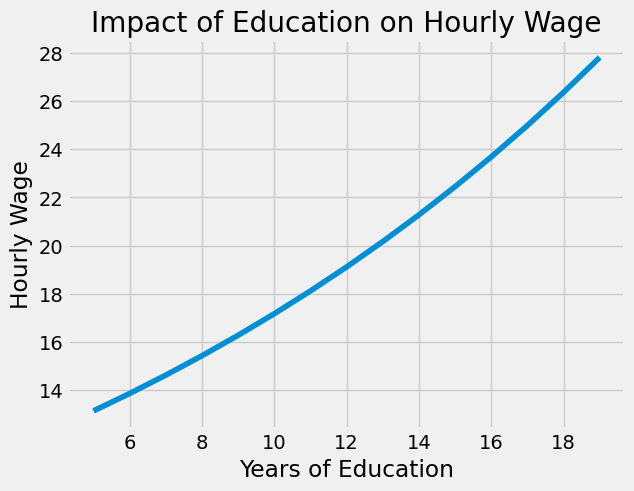

In [47]:
from matplotlib import pyplot as plt
from matplotlib import style
style.use("fivethirtyeight")

x = np.array(range(5, 20))
plt.plot(x, np.exp(model_1.params["Intercept"] + model_1.params["educ"] * x))
plt.xlabel("Years of Education")
plt.ylabel("Hourly Wage")
plt.title("Impact of Education on Hourly Wage")
plt.show()

当然，并非因为我们能估计这个简单模型就意味着它是正确的。请注意我措辞谨慎，说的是它根据教育程度**预测**工资。我从未说过这种预测具有因果性。事实上，此刻你很可能有充分理由认为该模型存在偏误。由于我们的数据并非来自随机实验，我们无法判断受教育年限较长者与较短者是否具有可比性。更进一步说，基于我们对现实世界的认知，可以非常确定二者并不具备可比性。具体而言，我们可以论证受教育年限更长的人可能拥有更富裕的父母，而我们所观察到的教育年限增加伴随工资上升的现象，只是反映了家庭财富与受教育年限之间的关联。用数学术语表达，我们认为 $E[Y_0|T=0] < E[Y_0|T=1]$，即无论如何，那些受教育更多的人即便没有接受这么多年的教育，收入也会更高。若对教育持极端悲观态度，你甚至可以认为教育会因使人脱离劳动力市场并降低工作经验而减少工资。

幸运的是，在我们的数据中，我们可以获取许多其他变量。我们可以看到父母的教育程度 `meduc` 、 `feduc` ，个人的 `IQ` 分数，工作经验年限 `exper` 以及该人员当前公司的在职时间 `tenure` 。我们甚至还有一些关于婚姻状况和黑人种族的虚拟变量。

```{dropdown} 查看 Stata 代码
```stata
list in 1/5

In [50]:
wage.head()

,wage,hours,lhwage,IQ,educ,exper,tenure,age,married,black,south,urban,sibs,brthord,meduc,feduc
0,769,40,2.956212,93,12,11,2,31,1,0,0,1,1,2.0,8.0,8.0
2,825,40,3.026504,108,14,11,9,33,1,0,0,1,1,2.0,14.0,14.0
3,650,40,2.788093,96,12,13,7,32,1,0,0,1,4,3.0,12.0,12.0
4,562,40,2.642622,74,11,14,5,34,1,0,0,1,10,6.0,6.0,11.0
6,600,40,2.708050,91,10,13,0,30,0,0,0,1,1,2.0,8.0,8.0


我们可以将所有额外的变量纳入模型并进行估计：

$
log(hwage)_i = \beta_0 + \kappa \ educ_i + \pmb{\beta}X_i + u_i
$

要理解这如何有助于解决偏误问题，让我们回顾多元线性回归的双变量分解。

$
\kappa = \dfrac{Cov(Y_i, \tilde{T_i})}{Var(\tilde{T_i})} 
$

该公式表明，我们可以通过父母的教育程度、智商、经验等因素来预测 `educ` 。完成这一步后，我们将得到一个与之前包含的所有变量均不相关的 `educ` 版本，即 $\tilde{educ}$。这将瓦解诸如“受教育年限更长的人之所以如此，是因为他们拥有更高的智商。教育并不会带来更高的工资，只是与智商相关，而智商才是驱动工资的因素”之类的论点。那么，如果我们在模型中纳入智商变量，那么 $\kappa$ 就代表在保持智商不变的情况下，每多接受一年教育所带来的回报。稍作停顿，思考一下这意味着什么。即便我们无法通过随机对照试验使处理组和对照组的其他因素保持一致，回归分析也能通过将这些相同因素纳入模型来实现这一点，即使数据并非随机！

```{dropdown} 查看 Stata 代码
```stata
// Define control variables
global controls iq exper tenure age married black south urban sibs brthord meduc feduc

// Create constant term (intercept)
gen intercep = 1

// Step 1: Auxiliary regression of education (endogenous treatment) on controls
reg educ $controls intercep

// Step 2: Compute residuals from auxiliary regression
predict t_tilde, residuals

// Step 3: Calculate covariance between residuals and outcome variable (lhwage)
corr t_tilde lhwage, covariance
scalar cov_ty = r(cov_12)  // Stores covariance in scalar

// Step 4: Calculate variance of residuals
sum t_tilde
scalar var_t = r(Var)  // Stores residual variance in scalar

// Step 5: Compute kappa estimator (local treatment effect)
scalar kappa = cov_ty/var_t

// Display the final result
display "Local average treatment effect (kappa) = " kappa


In [53]:
controls = ['IQ', 'exper', 'tenure', 'age', 'married', 'black',
            'south', 'urban', 'sibs', 'brthord', 'meduc', 'feduc']

X = wage[controls].assign(intercep=1)
t = wage["educ"]
y = wage["lhwage"]

beta_aux = regress(t, X)
t_tilde = t - X.dot(beta_aux)

kappa = t_tilde.cov(y) / t_tilde.var()
kappa

0.04114719101005912

我们刚刚估算的这个系数表明，对于智商、经验、任期、年龄等条件相同的人群，每多接受一年教育，预计每小时工资将增加 4.11%。这证实了我们最初的怀疑：仅包含 `educ` 的简单初始模型存在偏误。同时，该结果也验证了这种偏误高估了教育的影响——在控制其他变量后，教育对工资的估计效应有所下降。

如果我们更明智地利用他人编写的软件而非事必躬亲地编码，甚至可以为这一估计值设置一个置信区间。

```{dropdown} 查看 Stata 代码
```stata
// Run OLS regression with estout output
reg lhwage educ $controls
eststo ols_model

// Display results using esttab
* ssc install estout, replace
esttab ols_model, ///
    cells(b(star fmt(3)) se(par fmt(2))) ///
    stats(N r2, fmt(0 3)) ///
    title("OLS Estimation Results") ///
    label

In [56]:
model_2 = smf.ols('lhwage ~ educ +' + '+'.join(controls), data=wage).fit()
model_2.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,1.1156,0.232,4.802,0.000,0.659,1.572
educ,0.0411,0.010,4.075,0.000,0.021,0.061
IQ,0.0038,0.001,2.794,0.005,0.001,0.006
exper,0.0153,0.005,3.032,0.003,0.005,0.025
tenure,0.0094,0.003,2.836,0.005,0.003,0.016
age,0.0086,0.006,1.364,0.173,-0.004,0.021
married,0.1795,0.053,3.415,0.001,0.076,0.283
black,-0.0801,0.063,-1.263,0.207,-0.205,0.044
south,-0.0397,0.035,-1.129,0.259,-0.109,0.029
urban,0.1926,0.036,5.418,0.000,0.123,0.262


## 遗漏变量与混杂偏误

剩下的问题是：我们估计的这个参数是否具有因果性？遗憾的是，我们无法确定。可以认为，最初仅将工资对教育程度进行回归的简单模型很可能并不具备因果性。该模型遗漏了与教育程度和工资均相关的重要变量。若不对这些变量加以控制，教育程度的估计效应实际上也包含了模型中未纳入的其他变量的影响。

为了更好地理解这种偏误如何运作，假设教育影响工资的真实模型大致如下

$
Wage_i = \alpha + \kappa \ Educ_i + A_i'\beta + u_i
$

工资受教育影响，其影响程度由 $\kappa$ 的大小衡量，同时还受其他能力因素（记为向量$A$）的作用。若在模型中忽略能力变量，对 $\kappa$ 的估计将呈现如下形式：

$
\dfrac{Cov(Wage_i, Educ_i)}{Var(Educ_i)} = \kappa + \beta'\delta_{Ability}
$

其中 $\delta_{A}$ 是 $A$ 对 $Educ$ 进行回归所得的系数向量

这里的关键在于，我们得到的并非完全是我们想要的 $\kappa$ ，而是附带了一个令人烦恼的额外项 $\beta'\delta_{A}$。这一项是被省略的 $A$ 对 $Wage$的影响，乘以被省略项对已包含项 $Educ$的影响（$\beta$）。 对于经济学家来说，这是一个非常重要的概念，以至于 Joshua Angrist 把它变成了一种“口头禅”，让学生们可以在冥想中反复默念它。

```
“简约（短）等于完整（长），
加上遗漏变量的影响，
再乘遗漏对包含变量的回归。”
```

在此，短回归是指省略变量的模型，而长回归则包含所有变量。这一公式或原则为我们进一步揭示了偏误的本质。首先，如果被忽略的变量对因变量没有影响 $Y$，那么偏误项将为零。这完全合乎逻辑——在试图理解教育对工资影响时，无需控制与之无关的因素（比如田野百合的高度）。其次，若被忽略的变量对处理变量也无影响，偏误项同样为零。这一点也直观易懂：如果模型中已包含所有影响教育的因素，那么教育对工资的估计影响就不可能混杂着教育与其他同样影响工资变量之间的相关性。

![img](images/05/confused_cat.png)

简而言之，**若模型中已纳入所有混淆变量，则可认为不存在遗漏变量偏误（OVB）**。我们亦可借助因果图的知识来理解这一点。混淆变量是指**同时影响处理变量和结果的变量**。以工资为例，智商（IQ）便是一个混淆因素。高智商者往往能完成更多年的教育，因为这对他们来说更为轻松，因此可以说智商影响了教育程度。同时，高智商者通常天生具有更高生产力，因而工资也更高，故智商亦影响工资。由于混淆变量会同时作用于处理变量和结果变量，我们用指向 T 和 Y 的箭头加以标注（此处以 $W$ 表示）。此外，正因果关系用红色标示，负因果关系则以蓝色标示。

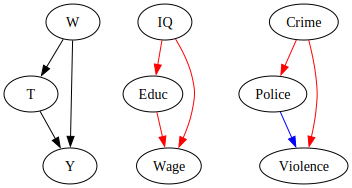

In [62]:
g = gr.Digraph()

g.edge("W", "T"), g.edge("W", "Y"), g.edge("T", "Y")

g.edge("IQ", "Educ", color="red"), g.edge("IQ", "Wage", color="red"), g.edge("Educ", "Wage", color="red")

g.edge("Crime", "Police", color="red"), g.edge("Crime", "Violence", color="red"), 
g.edge("Police", "Violence", color="blue")

g

因果图极佳地描绘了我们对世界的理解，并帮助我们理解混杂偏误如何运作。在我们的第一个例子中，有一个图表显示教育影响工资：更多教育带来更高的工资。然而，智商同样影响工资，并且也影响教育：高智商既导致更多教育，也导致更高工资。如果我们在模型中不考虑智商，它对工资的部分影响将通过教育相关性传递，这将使得教育的影响看起来比实际更大。这是一个正向偏误的例子。

再举一个带有负偏误的例子，考虑警察对城市暴力影响的因果图。我们通常在现实中看到的是，警力更强的城市暴力事件也更多。这是否意味着警察导致了暴力？或许吧，但在此我认为不值得深入讨论。然而，更有可能存在一个混杂变量，使我们看到警察对暴力影响的偏颇版本。可能是增加警力减少了暴力，但第三个变量——犯罪率——既导致了更多暴力，也促使了警力增强。若不加以控制，犯罪对暴力的影响将通过警力体现，使其看似增加了暴力。这便是负偏误的一个例证。

因果图还能向我们展示回归和随机对照试验如何正确应对混杂偏误。随机对照试验通过切断混杂因素与处理变量的联系来实现这一点。通过使处理变量$T$随机化，根据定义，没有任何因素能导致其变化。

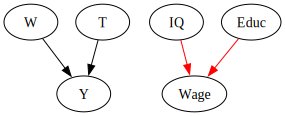

In [67]:
g = gr.Digraph()

g.edge("W", "Y"), g.edge("T", "Y")

g.edge("IQ", "Wage", color="red"), g.edge("Educ", "Wage", color="red")

g

另一方面，回归分析通过比较 $T$ 的影响来实现这一点，同时将混杂因素 $W$ 固定在一个水平上。回归分析并不意味着 W 不再影响 T 和 Y，而是将其固定，使其无法影响 T 和 Y 的变化。

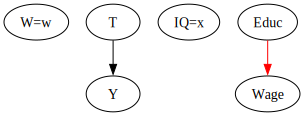

In [69]:
g = gr.Digraph()

g.node("W=w"), g.edge("T", "Y")
g.node("IQ=x"), g.edge("Educ", "Wage", color="red")

g

现在回到我们的问题上来，我们估计的 `educ` 对工资影响的参数是否具有因果性？很遗憾地告诉大家，这取决于我们能否论证模型已囊括所有混杂因素。我个人认为并未完全包括。例如，我们未将家庭财富纳入考量。即便加入了家庭教育背景，那也只能视为财富的替代指标。此外，我们还未考虑个人抱负等因素。可能是抱负既促使受教育年限增加又带来更高工资，因此它是一个混杂因素。这表明，**对于非随机或观察性数据的因果推断，我们应始终保持审慎态度**。永远无法确定所有混杂因素是否已被完全控制。

## 核心要点

我们通过回归分析探讨了诸多内容。我们了解到回归如何用于执行 A/B 测试，以及它如何便捷地提供置信区间。接着，我们研究了回归如何解决预测问题，并作为条件期望函数（CEF）的最佳线性近似。我们还讨论了在双变量情况下，回归处理系数是处理与结果之间的协方差除以处理的方差。扩展到多变量情形时，我们弄清了回归如何赋予处理系数一种“部分剔除”解释：即在保持其他所有包含变量不变的情况下，结果随处理的变化量。这正是经济学家喜欢称之为“其他条件不变”（ceteris paribus）的概念。

最后，我们转向了对偏误的理解。我们学习了那句口诀：

>短回归 = 长回归 + 遗漏变量的效应 × 遗漏变量对包含变量的回归系数

这让我们看清了偏误产生的机制。我们发现，遗漏变量偏误的根源是混杂变量：即同时影响处理和结果的变量。最后，我们借助因果图，看到了随机对照试验（RCT）和回归如何在不同条件下解决混杂问题。




## 参考文献
我愿将这一系列作品视为对 Joshua Angrist、Alberto Abadie 和 Christopher Walters 杰出计量经济学课程的致敬。第一部分的大部分思想源自他们在美国经济学会授课的内容。在艰难的 2020 年，正是观看他们的课程视频让我保持了理智。

 - [Cross-Section Econometrics](https://www.aeaweb.org/conference/cont-ed/2017-webcasts)
 - [Mastering Mostly Harmless Econometrics](https://www.aeaweb.org/conference/cont-ed/2020-webcasts)

 我还想引用 Angrist 的精彩著作。它们向我展示了计量经济学（他们称之为“Metrics”）不仅极为实用，而且充满乐趣。
 - [Mostly Harmless Econometrics](https://www.mostlyharmlesseconometrics.com)
 - [Mastering ‘Metrics](https://www.masteringmetrics.com)

最后还要感谢 Miguel Hernán 和 Jamie Robins 的[《Causal Inference》](https://hsph.harvard.edu/profile/miguel-hernan/)一书。它是我在面对最棘手的因果问题时的可靠伙伴。

![img](./images/poetry.png)

## 参与贡献

**《Causal Inference for the Brave and True》** 是一本关于因果推断的开源教材，致力于以经济上可负担、认知上可理解的方式，普及这门“科学的统计基础”。全书基于 Python，仅使用自由开源软件编写，原始英文版本由 [Matheus Facure](https://github.com/matheusfacure) 编写与维护。

本书的中文版由黄文喆与许文立教授合作翻译，并托管在 [GitHub 中文主页](https://github.com/Wenzhe-Huang/python-causality-handbook-zh)。希望本地化的内容能帮助更多中文读者学习和掌握因果推断方法。

如果你觉得这本书对你有帮助，并希望支持该项目，可以前往 [Patreon](https://www.patreon.com/causal_inference_for_the_brave_and_true) 支持原作者。

如果你暂时不方便进行经济支持，也可以通过以下方式参与贡献：

* 修正错别字
* 提出翻译或表达建议
* 反馈你未能理解的部分内容

欢迎前往英文版或中文版仓库点击 [issues 区](https://github.com/matheusfacure/python-causality-handbook/issues) 或 [中文版 issues 区](https://github.com/Wenzhe-Huang/python-causality-handbook-zh/issues) 提出反馈。

最后，如果你喜欢这本书的内容，也请将其分享给可能感兴趣的朋友，并为项目在 GitHub 上点亮一颗星：[英文版仓库](https://github.com/matheusfacure/python-causality-handbook) / [中文版仓库](https://github.com/Wenzhe-Huang/python-causality-handbook-zh)。